## SECTION 1 :Business understanding
    Introduction
As part of the Data Science Nanodegree by Udacity, this project delves into the realm of predictive analytics within the context of customer behavior analysis using simulated data from Starbucks' mobile app. The objective is to unravel insights that can optimize marketing strategies by predicting which types of promotional offers will generate the highest response rates from customers.

In today's competitive landscape, businesses like Starbucks continually strive to tailor their promotional efforts to individual customer preferences. By harnessing demographic data such as age, gender, and income alongside detailed offer attributes like type, difficulty, and duration, this project aims to build a predictive model. This model will forecast customer actions such as offer reception, viewing, and completion.

Through rigorous analysis and modeling, this study seeks to provide actionable insights that empower Starbucks to deploy targeted marketing campaigns effectively. By understanding and anticipating customer responses, Starbucks can enhance user engagement, boost customer satisfaction, and optimize resource allocation for maximum business impact.

This project not only showcases the application of data science techniques in real-world business scenarios but also aims to deliver practical solutions that drive strategic decision-making within the Starbucks ecosystem.

# Problem Statement :
Predicting which purchase offers will elicit a higher level of response, such as 'offer received', 'offer viewed', 'transaction', and 'offer completed', based on both demographic attributes of customers and other characteristics of the company's offers.

## Metrics:

The model's performance will be evaluated using precision, recall, F1-score, and accuracy. These metrics will help determine how well the model predicts the various user actions.

## Data Sets

The data is contained in three files:

1. **portfolio.json** - Contains offer IDs and metadata about each offer (duration, type, etc.).
2. **profile.json** - Contains demographic data for each customer.
3. **transcript.json** - Records for transactions, offers received, offers viewed, and offers completed.

### Schema and Explanation of Each Variable

#### portfolio.json
- `id` (string): Offer ID.
- `offer_type` (string): Type of offer (e.g., BOGO, discount, informational).
- `difficulty` (int): Minimum required spend to complete an offer.
- `reward` (int): Reward given for completing an offer.
- `duration` (int): Duration of the offer.
- `channels` (list of strings): Channels through which the offer is available.

#### profile.json
- `age` (int): Age of the customer.
- `became_member_on` (int): Date when the customer created an app account.
- `gender` (str): Gender of the customer (note some entries contain 'O' for other rather than M or F).
- `id` (str): Customer ID.
- `income` (float): Customer's income.

#### transcript.json
- `event` (str): Record description (e.g., transaction, offer received, offer viewed, etc.).
- `person` (str): Customer ID.
- `time` (int): Time in hours. The data begins at time t=0.
- `value` (dict of strings): Either an offer ID or transaction amount depending on the record.

In [250]:
#import dependencies
import pandas as pd
import numpy as np
import math
import json
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

In [251]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [252]:
# read in the json files
portfolio_df = pd.read_json('portfolio.json', orient='records', lines=True)
profile_df = pd.read_json('profile.json', orient='records', lines=True)
transcript_df = pd.read_json('transcript.json', orient='records', lines=True)

##  SECTION 2: DATA UNDERSTANDING

In [67]:
portfolio_df.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [68]:
profile_df.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [69]:
transcript_df.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [70]:
portfolio_df.describe()

,reward,difficulty,duration
count,10.000000,10.000000,10.000000
mean,4.200000,7.700000,6.500000
std,3.583915,5.831905,2.321398
min,0.000000,0.000000,3.000000
25%,2.000000,5.000000,5.000000
50%,4.000000,8.500000,7.000000
75%,5.000000,10.000000,7.000000
max,10.000000,20.000000,10.000000


In [71]:
profile_df.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


In [72]:
transcript_df.describe()

,time
count,306534.000000
mean,366.382940
std,200.326314
min,0.000000
25%,186.000000
50%,408.000000
75%,528.000000
max,714.000000


In [73]:
portfolio_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes


In [74]:
profile_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


In [75]:
transcript_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [76]:
portfolio_df.shape

(10, 6)

In [77]:
profile_df.shape

(17000, 5)

In [78]:
transcript_df.shape

(306534, 4)

 ## SECTION 3 : Data Preparation & analysis


create a copy of the original dataframe for further implementation .convert the datatype of 'became_member_on' column and sort the date into proper format .
change the column name from 'ID' to 'customer_id' .

In [165]:
# Fill missing values
# For gender: fill with the mode (most frequent value)
profile_df['gender'].fillna(profile_df['gender'].mode()[0], inplace=True)

In [166]:
# For income: fill with the mean value
profile_df['income'].fillna(profile_df['income'].mean(), inplace=True)

In [167]:
df1 = portfolio_df.copy()

In [168]:
dummy = pd.get_dummies(df1.channels.apply(pd.Series).stack()).sum(level=0)
df1 = pd.concat([df1, dummy], axis=1)
df1 = df1.drop(columns='channels')

C:\Users\USER\AppData\Local\Temp\ipykernel_4568\3013958009.py:1: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  dummy = pd.get_dummies(df1.channels.apply(pd.Series).stack()).sum(level=0)


In [169]:
df1 = df1.rename(columns={'id':'offer_id'})

In [170]:
df1

,reward,difficulty,duration,offer_type,offer_id,email,mobile,social,web
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,0,1
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1
5,3,7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1
6,2,10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1
7,0,0,3,informational,5a8bc65990b245e5a138643cd4eb9837,1,1,1,0
8,5,5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1
9,2,10,7,discount,2906b810c7d4411798c6938adc9daaa5,1,1,0,1


In [171]:
df2 = profile_df.copy()

In [172]:
df2['became_member_on'] = pd.to_datetime(df2['became_member_on'], format='%Y%m%d')

In [173]:
df2 = df2.rename(columns={'id':'customer_id'})

In [174]:
df2.head(10)

,gender,age,customer_id,became_member_on,income
0,M,118,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,65404.991568
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.000000
2,M,118,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,65404.991568
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.000000
4,M,118,a03223e636434f42ac4c3df47e8bac43,2017-08-04,65404.991568
5,M,68,e2127556f4f64592b11af22de27a7932,2018-04-26,70000.000000
6,M,118,8ec6ce2a7e7949b1bf142def7d0e0586,2017-09-25,65404.991568
7,M,118,68617ca6246f4fbc85e91a2a49552598,2017-10-02,65404.991568
8,M,65,389bc3fa690240e798340f5a15918d5c,2018-02-09,53000.000000
9,M,118,8974fc5686fe429db53ddde067b88302,2016-11-22,65404.991568


In [175]:
type(df2.became_member_on[0])

pandas._libs.tslibs.timestamps.Timestamp

In [176]:
df3 = transcript_df.copy()

In [177]:
df3 = df3.rename(columns={'person':'customer_id'})

In [178]:
df3['event'] = df3['event'].str.replace(' ', '-')

In [179]:
df3['event'].value_counts()

transaction        138953
offer-received      76277
offer-viewed        57725
offer-completed     33579
Name: event, dtype: int64

In [180]:
dummy = pd.get_dummies(df3['event'])
df3 = pd.concat([df3, dummy], axis=1 )

In [181]:
df3.head()

,customer_id,event,value,time,offer-completed,offer-received,offer-viewed,transaction
0,78afa995795e4d85b5d9ceeca43f5fef,offer-received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,0,1,0,0
1,a03223e636434f42ac4c3df47e8bac43,offer-received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0,1,0,0
2,e2127556f4f64592b11af22de27a7932,offer-received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,0,1,0,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer-received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,0,1,0,0
4,68617ca6246f4fbc85e91a2a49552598,offer-received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,0,1,0,0


In [182]:
df3['offer_id'] = [[*i.values()][0]if [*i.keys()][0] in ['offer id','offer_id'] else None for i in df3.value]
df3['amount'] = [np.round([*i.values()][0], decimals=2)if [*i.keys()][0] == 'amount' else None for i in df3.value]

In [183]:
df3 = df3.drop(columns='value')

In [184]:
df3.head()

,customer_id,event,time,offer-completed,offer-received,offer-viewed,transaction,offer_id,amount
0,78afa995795e4d85b5d9ceeca43f5fef,offer-received,0,0,1,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
1,a03223e636434f42ac4c3df47e8bac43,offer-received,0,0,1,0,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN
2,e2127556f4f64592b11af22de27a7932,offer-received,0,0,1,0,0,2906b810c7d4411798c6938adc9daaa5,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer-received,0,0,1,0,0,fafdcd668e3743c1bb461111dcafc2a4,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer-received,0,0,1,0,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN


In [185]:
merged_df = pd.merge(df3, df2, on='customer_id')

In [186]:
merged_df

,customer_id,event,time,offer-completed,offer-received,offer-viewed,transaction,offer_id,amount,gender,age,became_member_on,income
0,78afa995795e4d85b5d9ceeca43f5fef,offer-received,0,0,1,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,F,75,2017-05-09,100000.000000
1,78afa995795e4d85b5d9ceeca43f5fef,offer-viewed,6,0,0,1,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,F,75,2017-05-09,100000.000000
2,78afa995795e4d85b5d9ceeca43f5fef,transaction,132,0,0,0,1,None,19.89,F,75,2017-05-09,100000.000000
3,78afa995795e4d85b5d9ceeca43f5fef,offer-completed,132,1,0,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,F,75,2017-05-09,100000.000000
4,78afa995795e4d85b5d9ceeca43f5fef,transaction,144,0,0,0,1,None,17.78,F,75,2017-05-09,100000.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
306529,912b9f623b9e4b4eb99b6dc919f09a93,offer-received,576,0,1,0,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,M,118,2017-09-26,65404.991568
306530,912b9f623b9e4b4eb99b6dc919f09a93,offer-viewed,594,0,0,1,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,M,118,2017-09-26,65404.991568
306531,3045af4e98794a04a5542d3eac939b1f,offer-received,576,0,1,0,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,F,58,2016-10-20,78000.000000
306532,3045af4e98794a04a5542d3eac939b1f,offer-viewed,576,0,0,1,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,F,58,2016-10-20,78000.000000


In [187]:
main_df = pd.merge(merged_df, df1, on='offer_id', how='left')
main_df

,customer_id,event,time,offer-completed,offer-received,offer-viewed,transaction,offer_id,amount,gender,...,became_member_on,income,reward,difficulty,duration,offer_type,email,mobile,social,web
0,78afa995795e4d85b5d9ceeca43f5fef,offer-received,0,0,1,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,F,...,2017-05-09,100000.000000,5.0,5.0,7.0,bogo,1.0,1.0,0.0,1.0
1,78afa995795e4d85b5d9ceeca43f5fef,offer-viewed,6,0,0,1,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,F,...,2017-05-09,100000.000000,5.0,5.0,7.0,bogo,1.0,1.0,0.0,1.0
2,78afa995795e4d85b5d9ceeca43f5fef,transaction,132,0,0,0,1,None,19.89,F,...,2017-05-09,100000.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,78afa995795e4d85b5d9ceeca43f5fef,offer-completed,132,1,0,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,F,...,2017-05-09,100000.000000,5.0,5.0,7.0,bogo,1.0,1.0,0.0,1.0
4,78afa995795e4d85b5d9ceeca43f5fef,transaction,144,0,0,0,1,None,17.78,F,...,2017-05-09,100000.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
306529,912b9f623b9e4b4eb99b6dc919f09a93,offer-received,576,0,1,0,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,M,...,2017-09-26,65404.991568,10.0,10.0,5.0,bogo,1.0,1.0,1.0,1.0
306530,912b9f623b9e4b4eb99b6dc919f09a93,offer-viewed,594,0,0,1,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,M,...,2017-09-26,65404.991568,10.0,10.0,5.0,bogo,1.0,1.0,1.0,1.0
306531,3045af4e98794a04a5542d3eac939b1f,offer-received,576,0,1,0,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,F,...,2016-10-20,78000.000000,10.0,10.0,5.0,bogo,1.0,1.0,1.0,1.0
306532,3045af4e98794a04a5542d3eac939b1f,offer-viewed,576,0,0,1,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,F,...,2016-10-20,78000.000000,10.0,10.0,5.0,bogo,1.0,1.0,1.0,1.0


In [188]:
offer_id = main_df['offer_id'].unique()
offer_id

array(['9b98b8c7a33c4b65b9aebfe6a799e6d9', None,
       '5a8bc65990b245e5a138643cd4eb9837',
       'ae264e3637204a6fb9bb56bc8210ddfd',
       'f19421c1d4aa40978ebb69ca19b0e20d',
       '0b1e1539f2cc45b7b9fa7c272da2e1d7',
       '3f207df678b143eea3cee63160fa8bed',
       '2906b810c7d4411798c6938adc9daaa5',
       'fafdcd668e3743c1bb461111dcafc2a4',
       '4d5c57ea9a6940dd891ad53e9dbe8da0',
       '2298d6c36e964ae4a3e7e9706d1fb8c2'], dtype=object)

In [189]:
offer_dict = pd.Series(offer_id ).to_dict()
offer_dict

{0: '9b98b8c7a33c4b65b9aebfe6a799e6d9',
 1: None,
 2: '5a8bc65990b245e5a138643cd4eb9837',
 3: 'ae264e3637204a6fb9bb56bc8210ddfd',
 4: 'f19421c1d4aa40978ebb69ca19b0e20d',
 5: '0b1e1539f2cc45b7b9fa7c272da2e1d7',
 6: '3f207df678b143eea3cee63160fa8bed',
 7: '2906b810c7d4411798c6938adc9daaa5',
 8: 'fafdcd668e3743c1bb461111dcafc2a4',
 9: '4d5c57ea9a6940dd891ad53e9dbe8da0',
 10: '2298d6c36e964ae4a3e7e9706d1fb8c2'}

In [190]:
offer_dict = dict([(value, key) for key, value in offer_dict.items()]) 
offer_dict

{'9b98b8c7a33c4b65b9aebfe6a799e6d9': 0,
 None: 1,
 '5a8bc65990b245e5a138643cd4eb9837': 2,
 'ae264e3637204a6fb9bb56bc8210ddfd': 3,
 'f19421c1d4aa40978ebb69ca19b0e20d': 4,
 '0b1e1539f2cc45b7b9fa7c272da2e1d7': 5,
 '3f207df678b143eea3cee63160fa8bed': 6,
 '2906b810c7d4411798c6938adc9daaa5': 7,
 'fafdcd668e3743c1bb461111dcafc2a4': 8,
 '4d5c57ea9a6940dd891ad53e9dbe8da0': 9,
 '2298d6c36e964ae4a3e7e9706d1fb8c2': 10}

In [191]:
main_df['offer_id'] = main_df['offer_id'].map(offer_dict)
main_df.head()

,customer_id,event,time,offer-completed,offer-received,offer-viewed,transaction,offer_id,amount,gender,...,became_member_on,income,reward,difficulty,duration,offer_type,email,mobile,social,web
0,78afa995795e4d85b5d9ceeca43f5fef,offer-received,0,0,1,0,0,0,NaN,F,...,2017-05-09,100000.0,5.0,5.0,7.0,bogo,1.0,1.0,0.0,1.0
1,78afa995795e4d85b5d9ceeca43f5fef,offer-viewed,6,0,0,1,0,0,NaN,F,...,2017-05-09,100000.0,5.0,5.0,7.0,bogo,1.0,1.0,0.0,1.0
2,78afa995795e4d85b5d9ceeca43f5fef,transaction,132,0,0,0,1,1,19.89,F,...,2017-05-09,100000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,78afa995795e4d85b5d9ceeca43f5fef,offer-completed,132,1,0,0,0,0,NaN,F,...,2017-05-09,100000.0,5.0,5.0,7.0,bogo,1.0,1.0,0.0,1.0
4,78afa995795e4d85b5d9ceeca43f5fef,transaction,144,0,0,0,1,1,17.78,F,...,2017-05-09,100000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [192]:
main_df['offer_id'] = main_df['offer_id'].replace(1, np.nan)

In [193]:
main_df.head()

,customer_id,event,time,offer-completed,offer-received,offer-viewed,transaction,offer_id,amount,gender,...,became_member_on,income,reward,difficulty,duration,offer_type,email,mobile,social,web
0,78afa995795e4d85b5d9ceeca43f5fef,offer-received,0,0,1,0,0,0.0,NaN,F,...,2017-05-09,100000.0,5.0,5.0,7.0,bogo,1.0,1.0,0.0,1.0
1,78afa995795e4d85b5d9ceeca43f5fef,offer-viewed,6,0,0,1,0,0.0,NaN,F,...,2017-05-09,100000.0,5.0,5.0,7.0,bogo,1.0,1.0,0.0,1.0
2,78afa995795e4d85b5d9ceeca43f5fef,transaction,132,0,0,0,1,NaN,19.89,F,...,2017-05-09,100000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,78afa995795e4d85b5d9ceeca43f5fef,offer-completed,132,1,0,0,0,0.0,NaN,F,...,2017-05-09,100000.0,5.0,5.0,7.0,bogo,1.0,1.0,0.0,1.0
4,78afa995795e4d85b5d9ceeca43f5fef,transaction,144,0,0,0,1,NaN,17.78,F,...,2017-05-09,100000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [194]:
main_df['offer_id'].unique()

array([ 0., nan,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])

In [195]:
event_ids = main_df['event'].unique()
event_ids

array(['offer-received', 'offer-viewed', 'transaction', 'offer-completed'],
      dtype=object)

In [196]:
event_dict = pd.Series(event_ids).to_dict()
event_dict

{0: 'offer-received',
 1: 'offer-viewed',
 2: 'transaction',
 3: 'offer-completed'}

In [197]:
event_dict = dict([(value, key) for key, value in event_dict.items()]) 
event_dict

{'offer-received': 0,
 'offer-viewed': 1,
 'transaction': 2,
 'offer-completed': 3}

In [198]:
#map event_ids to the encoded event ids
main_df['event_id'] = main_df['event'].map(event_dict)

In [199]:
main_df.head()

,customer_id,event,time,offer-completed,offer-received,offer-viewed,transaction,offer_id,amount,gender,...,income,reward,difficulty,duration,offer_type,email,mobile,social,web,event_id
0,78afa995795e4d85b5d9ceeca43f5fef,offer-received,0,0,1,0,0,0.0,NaN,F,...,100000.0,5.0,5.0,7.0,bogo,1.0,1.0,0.0,1.0,0
1,78afa995795e4d85b5d9ceeca43f5fef,offer-viewed,6,0,0,1,0,0.0,NaN,F,...,100000.0,5.0,5.0,7.0,bogo,1.0,1.0,0.0,1.0,1
2,78afa995795e4d85b5d9ceeca43f5fef,transaction,132,0,0,0,1,NaN,19.89,F,...,100000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
3,78afa995795e4d85b5d9ceeca43f5fef,offer-completed,132,1,0,0,0,0.0,NaN,F,...,100000.0,5.0,5.0,7.0,bogo,1.0,1.0,0.0,1.0,3
4,78afa995795e4d85b5d9ceeca43f5fef,transaction,144,0,0,0,1,NaN,17.78,F,...,100000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2


In [200]:
main_df.shape

(306534, 22)

In [201]:
main_df.columns

Index(['customer_id', 'event', 'time', 'offer-completed', 'offer-received',
       'offer-viewed', 'transaction', 'offer_id', 'amount', 'gender', 'age',
       'became_member_on', 'income', 'reward', 'difficulty', 'duration',
       'offer_type', 'email', 'mobile', 'social', 'web', 'event_id'],
      dtype='object')

In [202]:
main_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 306534 entries, 0 to 306533
Data columns (total 22 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   customer_id       306534 non-null  object        
 1   event             306534 non-null  object        
 2   time              306534 non-null  int64         
 3   offer-completed   306534 non-null  uint8         
 4   offer-received    306534 non-null  uint8         
 5   offer-viewed      306534 non-null  uint8         
 6   transaction       306534 non-null  uint8         
 7   offer_id          167581 non-null  float64       
 8   amount            138953 non-null  float64       
 9   gender            306534 non-null  object        
 10  age               306534 non-null  int64         
 11  became_member_on  306534 non-null  datetime64[ns]
 12  income            306534 non-null  float64       
 13  reward            167581 non-null  float64       
 14  diff

In [42]:
main_df.to_csv('main_df1.csv', index=False)

In [253]:
df = pd.read_csv('main_df1.csv')

# DATA PREPROCESSING AND ANALYSIS OF THE NEW MERGED DATA FRAME

## Data Exploration and Data Visualization :

In [206]:
df.age.describe()

count    306534.000000
mean         60.909367
std          26.032030
min          18.000000
25%          43.000000
50%          57.000000
75%          72.000000
max         118.000000
Name: age, dtype: float64

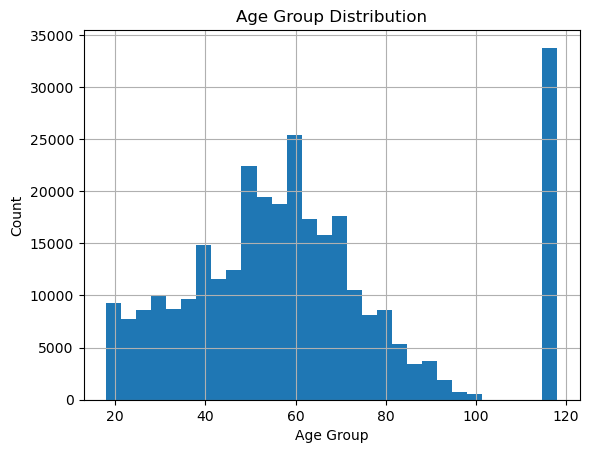

In [207]:
df.age.hist(bins = 30)
plt.xlabel('Age Group')
plt.ylabel('Count')
plt.title('Age Group Distribution');

# Observation :
Outlier is present Age > 115 is present is high amount , which does not make sense .
Average Aged user is middle age ie. around 50-62 years

In [208]:
df.income.describe()

count    306534.000000
mean      64454.665307
std       20042.155279
min       30000.000000
25%       50000.000000
50%       65404.991568
75%       75000.000000
max      120000.000000
Name: income, dtype: float64

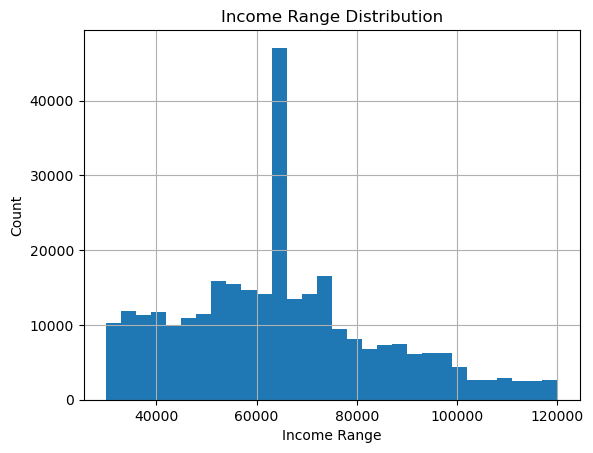

In [209]:
df.income.hist(bins = 30);
plt.xlabel('Income Range')
plt.ylabel('Count')
plt.title('Income Range Distribution');

# Observation :
Average income user is middle income group ie. 65000-70000

In [210]:
df.gender.value_counts()

M    189462
F    113101
O      3971
Name: gender, dtype: int64

In [211]:
male_proportion  = df.gender.value_counts()[0] / df.shape[0]*100
female_proportion = df.gender.value_counts()[1] / df.shape[0]*100
others_proportion = df.gender.value_counts()[2] / df.shape[0]*100

male_proportion ,female_proportion ,others_proportion

(61.807825559318054, 36.89672271265177, 1.2954517280301696)

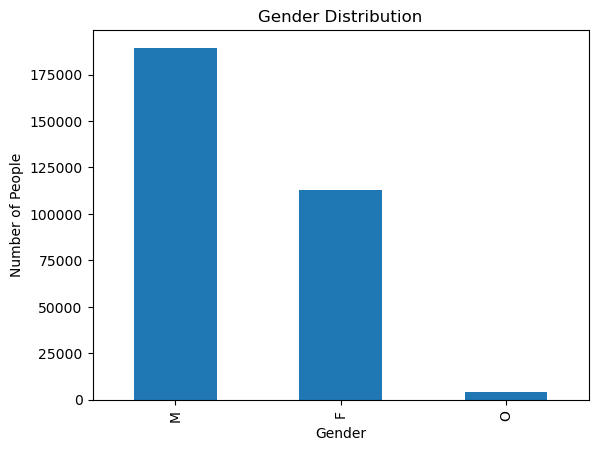

In [124]:
ax = df.gender.value_counts()
ax.plot(kind='bar')
plt.ylabel('Number of People')
plt.xlabel('Gender')
plt.title('Gender Distribution');

# Observation :
males make the majority of users .

In [212]:
offer_received = df[df['offer-received'] == 1].offer_type.value_counts()
offer_viewed = df[df['offer-viewed'] == 1].offer_type.value_counts()
offer_completed = df[df['offer-completed'] == 1].offer_type.value_counts()

offer_received , offer_viewed , offer_completed 

(discount         30543
 bogo             30499
 informational    15235
 Name: offer_type, dtype: int64,
 bogo             25449
 discount         21445
 informational    10831
 Name: offer_type, dtype: int64,
 discount    17910
 bogo        15669
 Name: offer_type, dtype: int64)

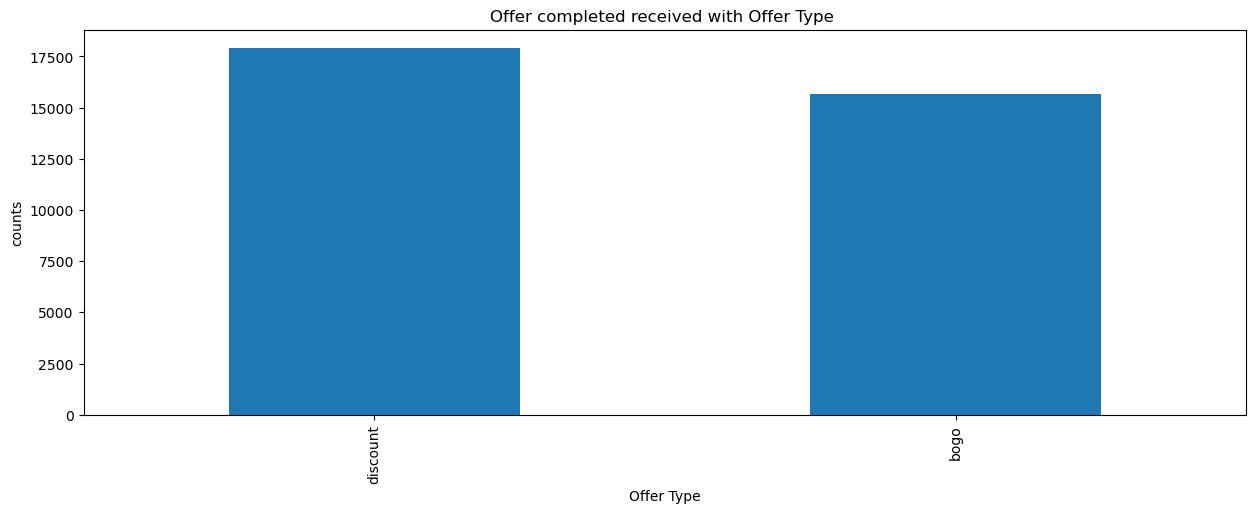

In [126]:
plt.subplot
offer_completed = df[df['offer-completed'] == 1].offer_type.value_counts()
offer_completed.plot(kind='bar' , figsize=(15,5))
plt.ylabel('counts')
plt.xlabel('Offer Type')
plt.title('Offer completed received with Offer Type ');

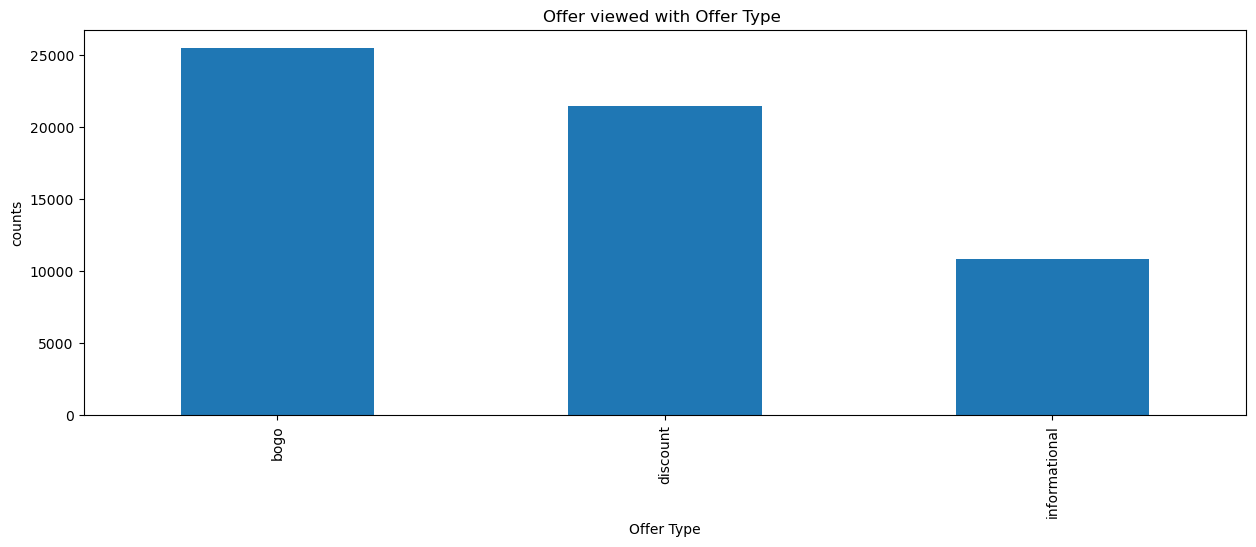

In [127]:
plt.subplot
offer_viewed = df[df['offer-viewed'] == 1].offer_type.value_counts()
offer_viewed.plot(kind='bar' , figsize=(15,5))
plt.ylabel('counts')
plt.xlabel('Offer Type')
plt.title('Offer viewed with Offer Type ');


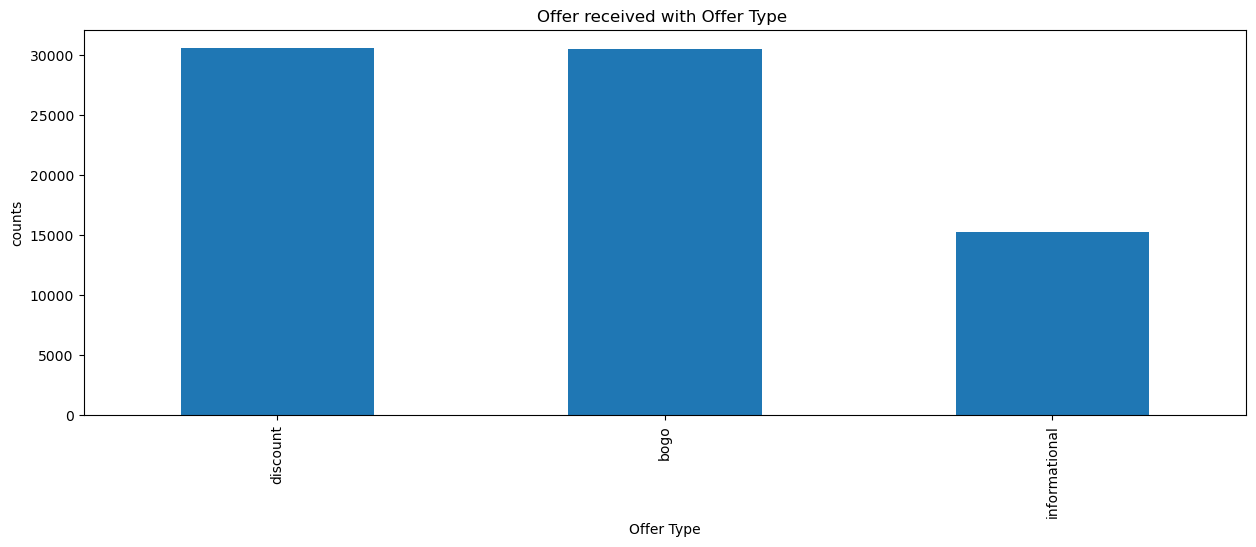

In [128]:
plt.subplot
offer_received = df[df['offer-received'] == 1].offer_type.value_counts()
offer_received.plot(kind='bar', figsize=(15,5))
plt.ylabel('counts')
plt.xlabel('Offer Type')
plt.title('Offer received with Offer Type ');


In [213]:
# For BOGO Offer :

R = offer_received[1] 
V = offer_viewed[0] 
C = offer_completed[1] 

view_prop = V/R
com_prop = C/R
R , V , C , view_prop 

(30499, 25449, 15669, 0.8344208006819895)

In [214]:
# For DISCOUNT Offer :

R = offer_received[0] 
V = offer_viewed[1] 
C = offer_completed[0] 

view_prop = V/R
com_prop = C/R
R , V , C , view_prop , com_prop

(30543, 21445, 17910, 0.702124873129686, 0.5863864060504862)

# Observation:
BOGO offers show significant demand, with 30,499 users receiving the offer, out of which 25,449 viewed it, and 15,669 completed it. This results in a viewing rate of 83% for BOGO offers.

In comparison, the viewing rate for DISCOUNT offers is slightly lower at 70%.

In [254]:
# Fill missing values
df['gender'].fillna('O', inplace=True)
df['income'].fillna(df['income'].median(), inplace=True)
df['reward'].fillna(0, inplace=True)
df['difficulty'].fillna(0, inplace=True)
df['duration'].fillna(0, inplace=True)
df['offer_type'].fillna('unknown', inplace=True)
df['email'].fillna(0, inplace=True)
df['mobile'].fillna(0, inplace=True)
df['social'].fillna(0, inplace=True)
df['web'].fillna(0, inplace=True)

In [256]:
df['amount'].fillna(0, inplace=True)

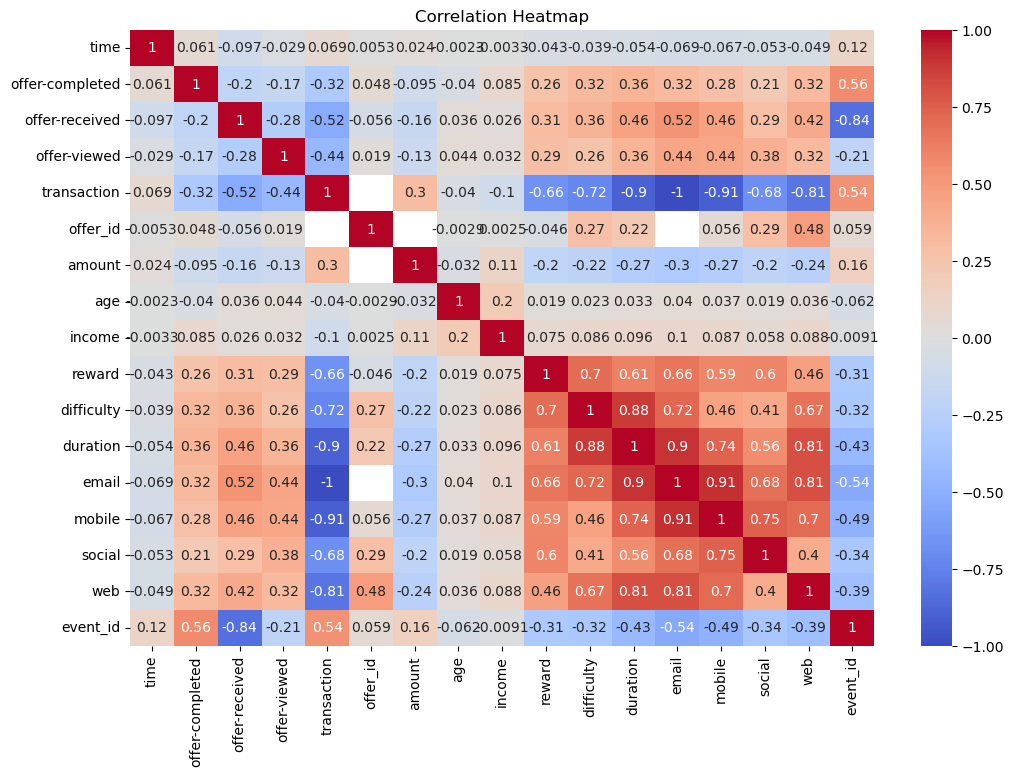

In [257]:
# Correlation heatmap
plt.figure(figsize=(12, 8))
correlation = df.corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

In [134]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 22 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   customer_id       306534 non-null  object 
 1   event             306534 non-null  object 
 2   time              306534 non-null  int64  
 3   offer-completed   306534 non-null  int64  
 4   offer-received    306534 non-null  int64  
 5   offer-viewed      306534 non-null  int64  
 6   transaction       306534 non-null  int64  
 7   offer_id          306534 non-null  object 
 8   amount            306534 non-null  float64
 9   gender            306534 non-null  object 
 10  age               306534 non-null  int64  
 11  became_member_on  306534 non-null  object 
 12  income            306534 non-null  float64
 13  reward            306534 non-null  float64
 14  difficulty        306534 non-null  float64
 15  duration          306534 non-null  float64
 16  offer_type        30

In [220]:
offer_received = df[df['offer-received'] == 1].offer_id.value_counts()
offer_viewed = df[df['offer-viewed'] == 1].offer_id.value_counts()
offer_completed = df[df['offer-completed'] == 1].offer_id.value_counts()

offer_received , offer_viewed , offer_completed 

(0.0     7677
 5.0     7668
 3.0     7658
 10.0    7646
 7.0     7632
 2.0     7618
 6.0     7617
 8.0     7597
 9.0     7593
 4.0     7571
 Name: offer_id, dtype: int64,
 10.0    7337
 8.0     7327
 9.0     7298
 4.0     7264
 3.0     6716
 2.0     6687
 0.0     4171
 6.0     4144
 7.0     4118
 5.0     2663
 Name: offer_id, dtype: int64,
 8.0     5317
 10.0    5156
 0.0     4354
 4.0     4296
 7.0     4017
 3.0     3688
 5.0     3420
 9.0     3331
 Name: offer_id, dtype: int64)

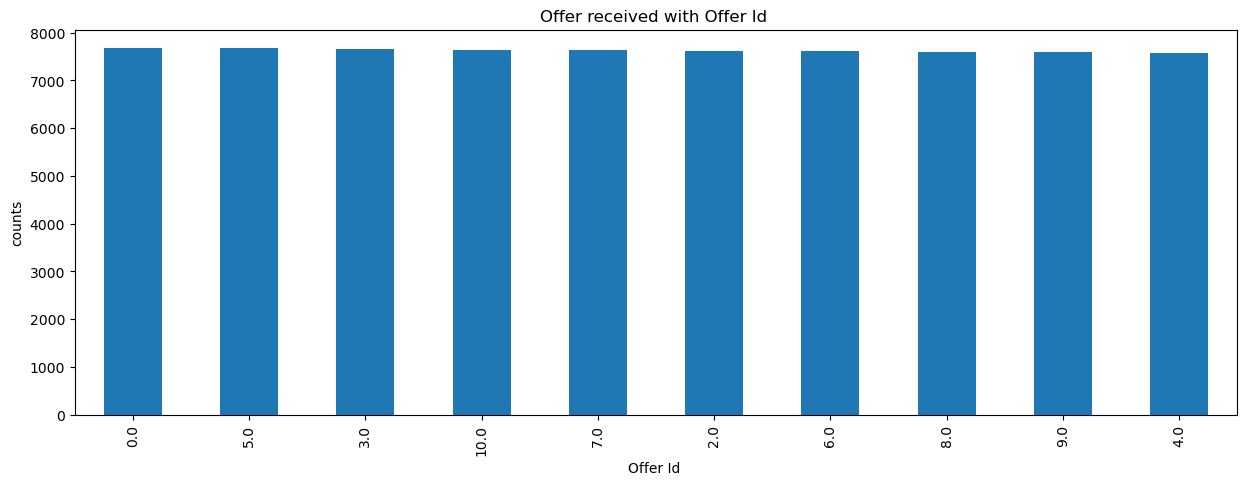

In [221]:
plt.subplot
offer_received = df[df['offer-received'] == 1].offer_id.value_counts()
offer_received.plot(kind='bar', figsize=(15,5))
plt.ylabel('counts')
plt.xlabel('Offer Id ')
plt.title('Offer received with Offer Id ');

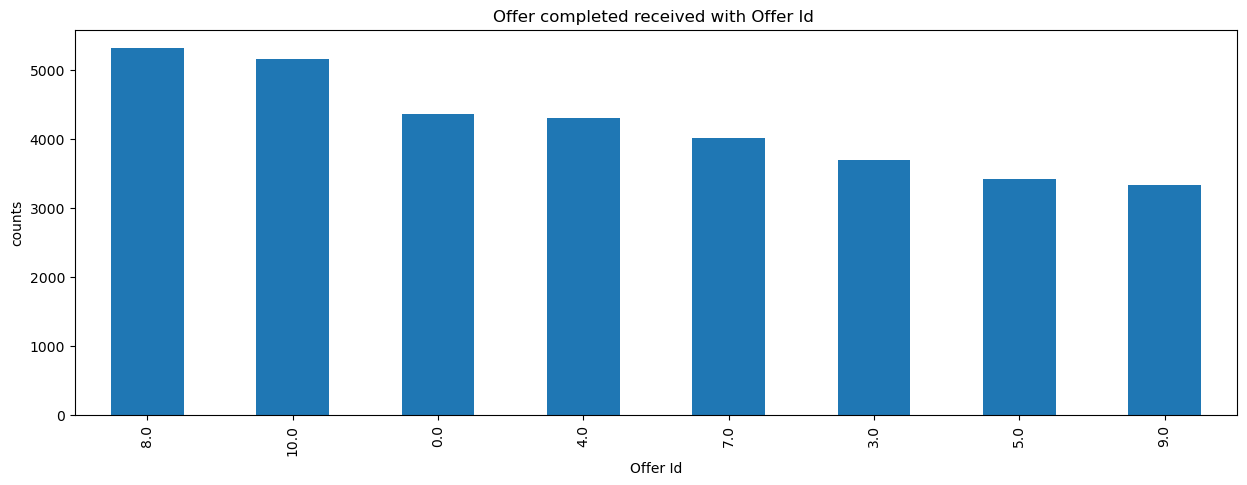

In [222]:
plt.subplot
offer_completed = df[df['offer-completed'] == 1].offer_id.value_counts()
offer_completed.plot(kind='bar' , figsize=(15,5))
plt.ylabel('counts')
plt.xlabel('Offer Id')
plt.title('Offer completed received with Offer Id ');

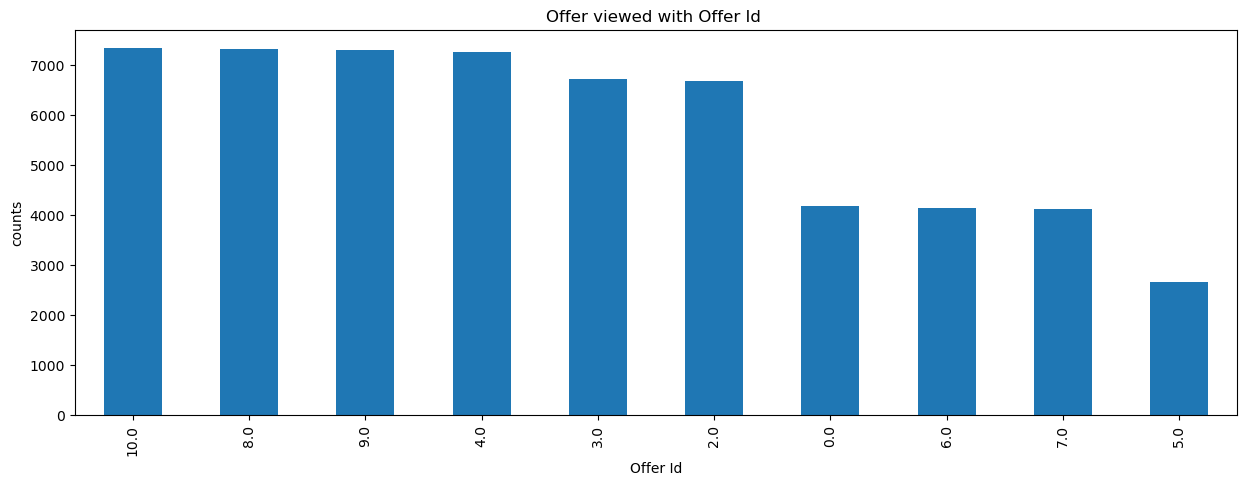

In [223]:
plt.subplot
offer_viewed = df[df['offer-viewed'] == 1].offer_id.value_counts()
offer_viewed.plot(kind='bar' , figsize=(15,5))
plt.ylabel('counts')
plt.xlabel('Offer Id')
plt.title('Offer viewed with Offer Id ');

# Observation:
Every offer_id received an equal number of offers.

However, the viewing ratio decreased for certain offer_ids, specifically offer_ids 0, 6, 7, and 5.

Despite this, the offer completion ratio remains quite decent overall.

In [224]:
df[df['offer_type']=='bogo'].groupby('customer_id')['offer-received'].count()

customer_id
0009655768c64bdeb2e877511632db8f    3
00116118485d4dfda04fdbaba9a87b5c    4
0011e0d4e6b944f998e987f904e8c1e5    3
0020c2b971eb4e9188eac86d93036a77    4
0020ccbbb6d84e358d3414a3ff76cffd    6
                                   ..
fff3ba4757bd42088c044ca26d73817a    3
fff7576017104bcc8677a8d63322b5e1    6
fff8957ea8b240a6b5e634b6ee8eafcf    2
fffad4f4828548d1b5583907f2e9906b    9
ffff82501cea40309d5fdd7edcca4a07    3
Name: offer-received, Length: 14992, dtype: int64

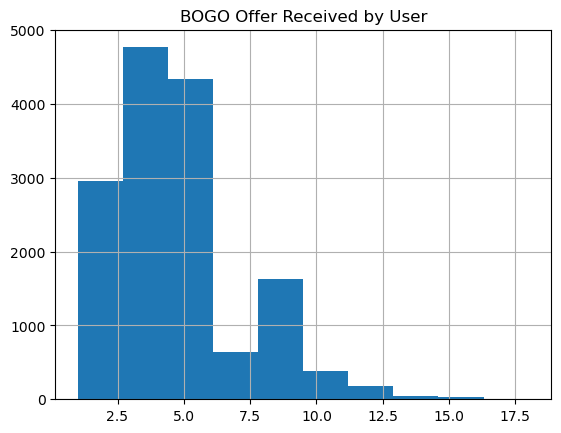

In [225]:
df[df['offer_type']=='bogo'].groupby('customer_id')['offer-received'].count().hist();
plt.title('BOGO Offer Received by User');


# Observation:
A considerable number of users received the BOGO offer.

In [226]:
df[df['offer_type']=='informational'].groupby('customer_id')['offer-viewed'].count()

customer_id
0009655768c64bdeb2e877511632db8f    4
0011e0d4e6b944f998e987f904e8c1e5    4
0020c2b971eb4e9188eac86d93036a77    2
0020ccbbb6d84e358d3414a3ff76cffd    2
003d66b6608740288d6cc97a6903f4f0    4
                                   ..
ffecb1f8543f4bf7bade023de366d6bf    2
fff0f0aac6c547b9b263080f09a5586a    4
fff3ba4757bd42088c044ca26d73817a    3
fff8957ea8b240a6b5e634b6ee8eafcf    1
fffad4f4828548d1b5583907f2e9906b    2
Name: offer-viewed, Length: 10547, dtype: int64

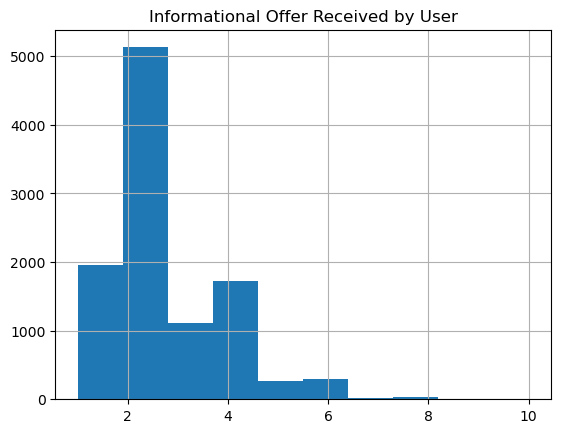

In [227]:
df[df['offer_type']=='informational'].groupby('customer_id')['offer-viewed'].count().hist();
plt.title('Informational Offer Received by User');

#Observation:

The ratio of 2 to 4 offer views is remarkably high, indicating a significant difference between the two.


In [228]:
df[df['offer_type']=='discount'].groupby('customer_id')['offer-completed'].count()

customer_id
0009655768c64bdeb2e877511632db8f     5
0011e0d4e6b944f998e987f904e8c1e5     6
0020c2b971eb4e9188eac86d93036a77     5
0020ccbbb6d84e358d3414a3ff76cffd     3
003d66b6608740288d6cc97a6903f4f0     8
                                    ..
fff29fb549084123bd046dbc5ceb4faa     3
fff3ba4757bd42088c044ca26d73817a     6
fff7576017104bcc8677a8d63322b5e1     6
fff8957ea8b240a6b5e634b6ee8eafcf     2
ffff82501cea40309d5fdd7edcca4a07    15
Name: offer-completed, Length: 14945, dtype: int64

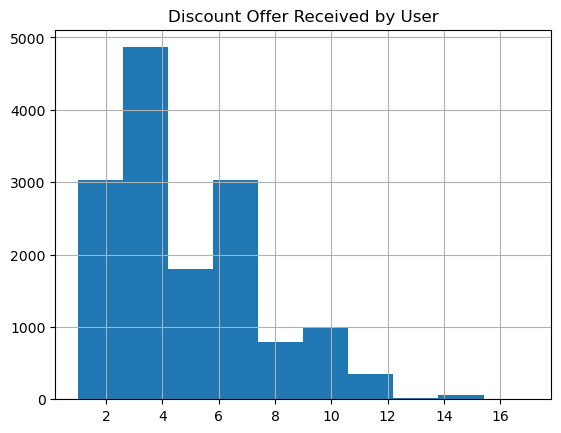

In [229]:
df[df['offer_type']=='discount'].groupby('customer_id')['offer-completed'].count().hist();
plt.title('Discount Offer Received by User');

# Observation:
The ratio of customers completing the offer 2 to 4 times is notably high.

## SECTION 4 : EVALUATE THE RESULTS¶

In [262]:
# Feature engineering
df['became_member_on'] = pd.to_datetime(df['became_member_on'])
df['membership_days'] = (pd.to_datetime('today') - df['became_member_on']).dt.days


# Reason for using RandomForestClassifier
For a multi-label classification task has several advantages due to the inherent properties and flexibility of the Random Forest algorithm. Here are the key reasons for choosing RandomForestClassifier:

1. Handling High Dimensionality
Random forests can handle a large number of input features and are robust to high-dimensional data. This is particularly useful in multi-label classification where each label can potentially depend on many features.

2. Managing Class Imbalance
Random forests can manage class imbalance by adjusting class weights or through techniques such as oversampling and undersampling. This is especially important in multi-label problems where some labels may be more frequent than others.


In [263]:
# Select features and target
X = df[['gender', 'age', 'income', 'reward', 'difficulty', 'duration',
        'offer_type', 'email', 'mobile', 'social', 'web', 'membership_days']]
y = df[['offer-completed', 'offer-received', 'offer-viewed', 'transaction']]

In [264]:
# Splitting into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [265]:

# Define preprocessing for categorical and numerical columns
categorical_cols = ['gender', 'offer_type']
numerical_cols = ['age', 'income', 'reward', 'difficulty', 'duration', 'email', 'mobile', 'social', 'web', 'membership_days']

In [266]:
# Create preprocessing pipelines for both numeric and categorical data
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])


In [267]:
# Define the model
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

In [268]:
# Train the model
model.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'income', 'reward',
                                                   'difficulty', 'duration',
                                                   'email', 'mobile', 'social',
                                                   'web', 'membership_days']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['gender', 'offer_type'])])),
                ('classifier', RandomForestClassifier(random_state=42))])

In [269]:
# Predictions
y_pred = model.predict(X_test)

In [270]:
# Model evaluation
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.01      0.00      0.01      6802
           1       0.23      0.20      0.21     15335
           2       0.05      0.04      0.04     11474
           3       1.00      1.00      1.00     27696

   micro avg       0.59      0.51      0.55     61307
   macro avg       0.32      0.31      0.32     61307
weighted avg       0.52      0.51      0.51     61307
 samples avg       0.51      0.51      0.51     61307



C:\Users\USER\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# Interpretation:
the model's performance is not satisfactory based on this classification report. Here are some potential issues and considerations:

Class Imbalance: The classes might be imbalanced, especially evident from the low support for classes 0, 1, and 2 compared to class 3 ('transaction'). This imbalance can skew the model's predictions and affect performance metrics.

Model Selection: RandomForestClassifier is used in the model, but its default parameters might not be optimal for your dataset. You might need to tune hyperparameters or consider other algorithms depending on your specific problem.

# LET'S TRY AND IMPROVE ON THIS

In [273]:
from sklearn.metrics import classification_report
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier

In [274]:
# Define the Logistic Regression model with OneVsRestClassifier
ovr_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', MultiOutputClassifier(LogisticRegression(solver='lbfgs', max_iter=1000, random_state=42)))
])

In [275]:
# Train the Logistic Regression model
ovr_model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'income', 'reward',
                                                   'difficulty', 'duration',
                                                   'email', 'mobile', 'social',
                                                   'web', 'membership_days']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['gender', 'offer_type'])])),
                ('classifier',
                 MultiOutputClassifier(estimator=LogisticRegression(max_iter=1000,
                                                                    random_state=42)))])

In [276]:
# Predictions
y_pred_ovr = ovr_model.predict(X_test)

In [277]:
# Model evaluation for Logistic Regression with OneVsRestClassifier
print("OneVsRest Logistic Regression Classifier Report")
print(classification_report(y_test, y_pred_ovr, target_names=y.columns))

OneVsRest Logistic Regression Classifier Report
                 precision    recall  f1-score   support

offer-completed       0.50      0.00      0.00      6802
 offer-received       0.57      0.35      0.44     15335
   offer-viewed       0.46      0.02      0.03     11474
    transaction       1.00      1.00      1.00     27696

      micro avg       0.88      0.54      0.67     61307
      macro avg       0.63      0.34      0.37     61307
   weighted avg       0.74      0.54      0.57     61307
    samples avg       0.54      0.54      0.54     61307



C:\Users\USER\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# observation
The performance of the OneVsRest Logistic Regression model indicates several issues, particularly with the "offer-completed" and "offer-viewed" labels, which have very low recall and F1-scores. The "transaction" label performs perfectly, but this might be due to class imbalance, where the "transaction" class dominates the dataset.